In [1]:
import glob
import pickle
import os
import re
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from sklearn import metrics
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from document import Document

FUNCTION_WORD_POS = [
'DET:ART',
'DET:POS',
'INT',
'KON',
'PRO',
'PRO:DEM',
'PRO:IND',
'PRO:PER',
'PRO:POS',
'PRO:REL',
'PRP',
'PRP:det',
]

In [3]:
def load_data():
    print('loading data...')
    file_paths = [f for f in glob.glob("../data/*.txt")]
    data = {}
    for path in file_paths:
        file = open(path , "rb")
        print('pickling ', path, '...')
        data[os.path.basename(path)] = pickle.load(file)
        file.close()
    print('done loading data.')
    return data

In [4]:
def generate_documents(input_data_dict):
    documents = []
    for file_path, tag_list in input_data_dict.items():
        label = get_label_from_file_path(file_path)
        documents.extend([Document(label, tag_list[x:x+1000]) for x in range(0, len(tag_list), 1000)])
    return documents

In [5]:
def get_label_from_file_path(file_path):
    label = re.search('(?<=-)(.+)(?=-)', file_path)
    if label is None:
        return file_path
    else:
        return label.group()

In [6]:
# code borrowed from https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features),
               feature_names[top_coefficients % len(feature_names)],
               rotation=60, ha='right')
    plt.show()

In [7]:
def features(tags_list):
    features = []
    for tags in tags_list:
        features.append(relative_function_word_feature(tags))
    return features

In [8]:
def relative_function_word_feature(tags):
    function_words = [tag.lemma for tag in tags if tag.pos in FUNCTION_WORD_POS]
    word_counts = dict(Counter(function_words))
    relative_word_counts = {word: word_counts[word] / len(function_words)
                            for word in word_counts.keys()}
    return relative_word_counts

In [15]:
book_data_dict = load_data()

loading data...
pickling  ../data/1801-Chateaubriand-ATALA.txt ...
pickling  ../data/1802-Chateaubriand-RENE.txt ...
pickling  ../data/1807-Chateaubriand-Les Aventures du dernier Abencerage.txt ...
pickling  ../data/1874-Zola-LA CONQUETE DE PLASSANS.txt ...
pickling  ../data/1875-Jules Verne-L'ÎLE MYSTÉRIEUSE.txt ...
pickling  ../data/1876-Gobineau Joseph-Nouvelles Asiatiques.txt ...
pickling  ../data/1878-Loti-Le Mariage de Loti.txt ...
pickling  ../data/1880-Zola-NANA.txt ...
pickling  ../data/1883-Maupassant-Contes et Nouvelles.txt ...
pickling  ../data/1883-Zola-AU BONHEUR DES DAMES.txt ...
pickling  ../data/1890-Zola-LA BETE HUMANINE.txt ...
pickling  ../data/1891-Huysmans-La bas.txt ...
pickling  ../data/1891-Zola-L'argent.txt ...
pickling  ../data/1892-Zola-LE DEBACLE.txt ...
pickling  ../data/1894-Jules Renard-Poil de Carotte.txt ...
pickling  ../data/1902-Colette-Claudine a l’École.txt ...
pickling  ../data/1904-Colette-Dialogues De Bêtes.txt ...
pickling  ../data/1906-Cla

In [16]:
documents = generate_documents(book_data_dict)

In [17]:
text_classifier = Pipeline([
        ('vect', DictVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier(random_state=42, penalty='l1'))
    ])

In [18]:
labels = [doc.label for doc in documents]
X = [doc.tag_list for doc in documents]
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.20)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:144: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                         precision    recall  f1-score   support

           Andre Breton       0.00      0.00      0.00         3
             Andre Gide       0.84      0.59      0.70        27
               Bernanos       0.33      0.12      0.18         8
                 Celine       0.97      0.76      0.86        93
          Chateaubriand       0.36      0.62      0.45         8
        Claude Farrère       0.43      0.25      0.32        12
                Colette       0.61      0.71      0.66        82
       Françoise Sagan       0.57      0.80      0.67         5
              Giraudoux       0.57      0.62      0.60        32
        Gobineau Joseph       0.67      0.09      0.15        23
               Huysmans       1.00      0.41      0.58        27
             Jean Giono       0.36      0.53      0.43        15
       Jean Paul Sartre       0.69      0.84      0.76        32
         Joseph Malegue       0.50      0.83      0.62        64
           Jules Renard 

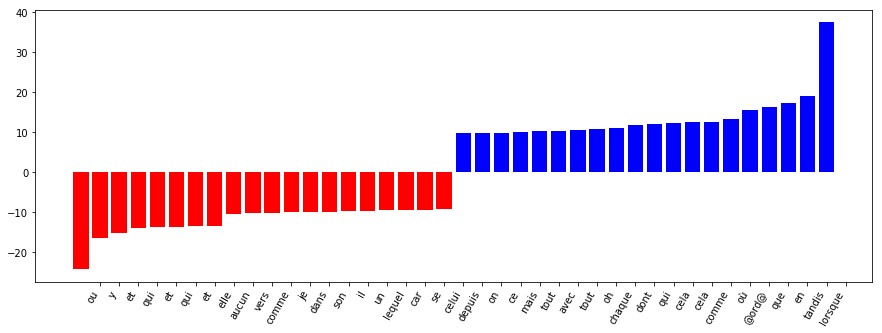

In [19]:
text_classifier.fit(features(X_train), y_train)
predicted = text_classifier.predict(features(X_test))
np.mean(predicted == y_test)
print(metrics.classification_report(y_test, predicted))
plot_coefficients(text_classifier.named_steps['clf'],
                  text_classifier.named_steps['vect'].get_feature_names())